# Clasificación con data de hundimiento del Titanic

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('pyspark-titanic').getOrCreate()

In [3]:
spark.version

'2.4.4'

In [4]:
dft = spark.read.csv('/dataset/titanic.csv', header=True)

In [5]:
dft.show(10)

+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+-----+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|    fare|  cabin|embarked|boat| body|           home.dest|
+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+-----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|29.0|    0|    0|   24160|211.3375|     B5|       S|   2| null|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.92|    1|    2|  113781|  151.55|C22 C26|       S|  11| null|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female| 2.0|    1|    2|  113781|  151.55|C22 C26|       S|null| null|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|30.0|    1|    2|  113781|  151.55|C22 C26|       S|null|135.0|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|25.0|    1|    2|  113781|  151.55|C22 C26|  

In [6]:
dft.printSchema()

root
 |-- pclass: string (nullable = true)
 |-- survived: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sibsp: string (nullable = true)
 |-- parch: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: string (nullable = true)
 |-- home.dest: string (nullable = true)



In [7]:
from pyspark.sql.types import DoubleType, IntegerType

In [8]:
dft = dft.withColumn('survived', dft['survived'].cast(IntegerType()))

In [9]:
dft.printSchema()

root
 |-- pclass: string (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sibsp: string (nullable = true)
 |-- parch: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: string (nullable = true)
 |-- home.dest: string (nullable = true)



In [14]:
dft.select('survived').show(5)

+--------+
|survived|
+--------+
|       1|
|       1|
|       0|
|       0|
|       0|
+--------+
only showing top 5 rows



In [67]:
dft.groupBy('survived').count().orderBy('count').show(10)

+--------+-----+
|survived|count|
+--------+-----+
|       1|  500|
|       0|  809|
+--------+-----+



## Extraccion (Ejercicio 1)

In [16]:
from pathlib import Path
import pandas as pd

In [17]:
def extract_titanic_data(url, refresh_cache=False):
    cache_fn = Path('/dataset/titanic_local.csv')
    if not cache_fn.exists() or refresh_cache:
        print("Getting data")
        df = pd.read_csv(url)
        df.to_csv(cache_fn, index=False)
    print("Using cache")
    df = spark.read.csv(str(cache_fn), header=True)
    return df

In [18]:
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv'

In [19]:
df_raw = extract_titanic_data(url)

Using cache


In [20]:
type(df_raw)

pyspark.sql.dataframe.DataFrame

In [21]:
df_raw.show(10)

+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+-----+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|    fare|  cabin|embarked|boat| body|           home.dest|
+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+-----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|29.0|    0|    0|   24160|211.3375|     B5|       S|   2| null|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.92|    1|    2|  113781|  151.55|C22 C26|       S|  11| null|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female| 2.0|    1|    2|  113781|  151.55|C22 C26|       S|null| null|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|30.0|    1|    2|  113781|  151.55|C22 C26|       S|null|135.0|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|25.0|    1|    2|  113781|  151.55|C22 C26|  

In [22]:
df_raw.printSchema()

root
 |-- pclass: string (nullable = true)
 |-- survived: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sibsp: string (nullable = true)
 |-- parch: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: string (nullable = true)
 |-- home.dest: string (nullable = true)



In [23]:
df_raw.count()

1309

In [47]:
# Train/test split
train_df, test_df = df_raw.randomSplit([0.7,0.3],seed=1234)

In [51]:
df_raw.randomSplit?

In [52]:
f.rand?

In [48]:
train_df.count()

959

In [59]:
from pyspark.sql.functions import rand, when
df_raw = df_raw.withColumn('train', when(rand(seed=1234) >= 0.3, True).otherwise(False))

In [60]:
df_raw.select('train').groupby('train').count().show()

+-----+-----+
|train|count|
+-----+-----+
| true|  886|
|false|  423|
+-----+-----+



In [33]:
df_raw.select('train').printSchema()

root
 |-- train: boolean (nullable = false)



In [34]:
import pyspark.sql.functions as f

In [37]:
df_train = df_raw.filter(f.col('train') == True)

In [39]:
df_train.count()

949

In [40]:
df_test = df_raw.filter(f.col('train') != True)

In [41]:
df_test.count()

360

## Ejercicio 2: Primer preproceso / EDA

In [62]:
# Casteo de datos
df_raw.printSchema()

root
 |-- pclass: string (nullable = true)
 |-- survived: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sibsp: string (nullable = true)
 |-- parch: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: string (nullable = true)
 |-- home.dest: string (nullable = true)
 |-- train: boolean (nullable = false)



In [68]:
def cast_cols(df, cols, new_type):
  for col in cols: 
     df = df.withColumn(col, df[col].cast(new_type()))
  return df

In [69]:
integer_cols = ['survived', 'sibsp', 'parch', 'body']
float_cols = ['age', 'fare']

In [70]:
df_raw = cast_cols(df_raw, integer_cols, IntegerType)
df_raw = cast_cols(df_raw, float_cols, DoubleType)

In [71]:
df_raw.printSchema()

root
 |-- pclass: string (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: integer (nullable = true)
 |-- home.dest: string (nullable = true)
 |-- train: boolean (nullable = false)



In [87]:
survived_on_boat = df_raw.filter((f.col('boat').isNotNull()) & (f.col('survived') == 1)).count()
survived = df_raw.filter(f.col('survived') == 1).count()
survived_on_boat / survived

0.954

In [88]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s-%(name)s-%(levelname)s: %(message)s',
    handlers=[logging.FileHandler('/dataset/titanic_spark.log'), logging.StreamHandler()],
)
logger = logging.getLogger(__name__)

In [94]:
def _drop_unusable_cols(df, cols=[]):
    logger.info(
        f"Dropping the following {len(cols)} unusable columns:\n"
        f"{cols}"
    )
    df = df.drop(*cols)
    logger.info(
        f"Remaining {len(df.columns)} columns:\n {sorted(df.columns)}"
    )
    return df

In [100]:
train_df = _drop_unusable_cols(train_df, cols=['boat', 'body', 'train'])

2019-12-10 02:01:25,224-__main__-INFO: Dropping the following 3 unusable columns:
['boat', 'body', 'train']
2019-12-10 02:01:25,252-__main__-INFO: Remaining 12 columns:
 ['age', 'cabin', 'embarked', 'fare', 'home.dest', 'name', 'parch', 'pclass', 'sex', 'sibsp', 'survived', 'ticket']


In [101]:
train_df.columns, test_df.columns

(['pclass',
  'survived',
  'name',
  'sex',
  'age',
  'sibsp',
  'parch',
  'ticket',
  'fare',
  'cabin',
  'embarked',
  'home.dest'],
 ['pclass',
  'survived',
  'name',
  'sex',
  'age',
  'sibsp',
  'parch',
  'ticket',
  'fare',
  'cabin',
  'embarked',
  'boat',
  'body',
  'home.dest',
  'train'])

In [102]:
test_df = _drop_unusable_cols(test_df, cols=['boat', 'body', 'train'])

2019-12-10 02:01:39,114-__main__-INFO: Dropping the following 3 unusable columns:
['boat', 'body', 'train']
2019-12-10 02:01:39,129-__main__-INFO: Remaining 12 columns:
 ['age', 'cabin', 'embarked', 'fare', 'home.dest', 'name', 'parch', 'pclass', 'sex', 'sibsp', 'survived', 'ticket']


In [111]:
train_df = train_df.withColumn('train_new', f.lit(True))
test_df = test_df.withColumn('train_new', f.lit(False))

In [115]:
joined_df = train_df.unionByName(test_df)
joined_df.count()

1309

In [117]:
df = _drop_unusable_cols(df_raw, cols=['boat', 'body'])

2019-12-10 02:14:11,775-__main__-INFO: Dropping the following 2 unusable columns:
['boat', 'body']
2019-12-10 02:14:11,804-__main__-INFO: Remaining 13 columns:
 ['age', 'cabin', 'embarked', 'fare', 'home.dest', 'name', 'parch', 'pclass', 'sex', 'sibsp', 'survived', 'ticket', 'train']


In [122]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

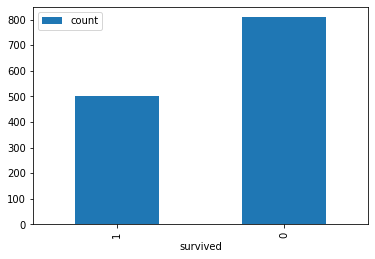

In [124]:
df.select('survived').groupBy('survived').count().toPandas().set_index('survived').plot.bar()

## EDA y Ejercicio 3

In [ ]:
import seaborn as sns

In [ ]:
g = sns.heatmap(df[['survived', 'age', 'parch', 'fare', 'sibsp']].corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")

In [ ]:
g = sns.FacetGrid(df, col='survived')
g = g.map(sns.distplot, 'age')

In [ ]:
g = sns.kdeplot(df['age'][(df['survived'] == 0) & 
                             (df['age'].notnull())], color='Red', shade = True)
g = sns.kdeplot(df['age'][(df['survived'] == 1) & 
                             (df['age'].notnull())], color='Blue', shade = True)
g.set_xlabel('age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [ ]:
df[df['fare'].isnull()]

In [ ]:
df['fare'].mean()

In [ ]:
df[df['fare'].fillna(df['fare'].mean()).isnull()]

In [ ]:
# Distribución de precio de boletos 
g = sns.distplot(df['fare'].fillna(df['fare'].mean()), color='m')

In [ ]:
df[df['fare'] == 0]

In [ ]:
df['fare'] = df['fare'].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.distplot(df['fare'].fillna(df['fare'].mean()), color='m')

In [ ]:
g = sns.barplot(x='sex', y='survived', data=df)
g = g.set_ylabel("Survival Probability")

In [ ]:
df[['sex', 'survived']].groupby('sex').mean()

In [ ]:
g = sns.factorplot(x='pclass', y='survived', hue='sex', data=df,
                   height=6, kind='bar')
g = g.set_ylabels("survival probability")

## Ejercicio 4: Valores nulos y constantes

In [ ]:
df.isnull().mean()

In [ ]:
df.info()

In [ ]:

(df.isnull().mean() < 0.5).index.tolist()
 

In [ ]:
def _drop_nulls(df, max_null_prop=0.5):
    logger.info(
        f"Dropping columns with null ratio greater than {max_null_prop * 100}%..."
    )
    null_means = df.isnull().mean()
    null_mask = null_means < max_null_prop
    null_mask[[c for c in null_mask.index.tolist() if c in PROTECTED_COLS]] = True
    drop_cols = null_mask[~null_mask].index.tolist()
    logger.info(
        f"null proportions:\n"
        f"{null_means.loc[drop_cols].sort_values(ascending=False)}"
    )

    logger.info(f"Dropping the following {len(drop_cols)} columns:\n {drop_cols}")

    df = df.drop(drop_cols, axis=1)
    return df

In [ ]:
PROTECTED_COLS = ['survived', 'train']
df = _drop_nulls(df)

In [ ]:
df.info()

In [ ]:
df.std()

In [ ]:
def _drop_std(df, min_std_dev=1.5e-2):
    std_values = df.std()
    low_variance_cols = std_values < min_std_dev
    low_variance_cols = low_variance_cols.index[low_variance_cols].tolist()
    low_variance_cols = [c for c in low_variance_cols if c not in PROTECTED_COLS]
    logger.info(
        f'Dropping the following {len(low_variance_cols)} columns '
        f'due to low variance:\n {low_variance_cols}'
    )
    df.drop(low_variance_cols, axis=1, inplace=True)
    return df

In [ ]:
df = _drop_std(df)

In [ ]:
df.info()

In [ ]:
assert 1 == 0

In [ ]:
def _get_typed_cols(df, col_type='cat'):
    assert col_type in ('cat', 'num')
    include = 'object' if col_type == 'cat' else [np.number]
    typed_cols = [
        c for c in df.select_dtypes(include=include).columns if c not in PROTECTED_COLS
    ]
    return typed_cols

In [ ]:
_get_typed_cols(df, col_type='foo')

In [ ]:
num_cols = _get_typed_cols(df, col_type='num')
cat_cols = _get_typed_cols(df, col_type='cat')
num_cols, cat_cols

In [ ]:
df['sex'].value_counts().index.to_list()[0]

In [ ]:
def _fill_nulls(df):
    for t in ['num', 'cat']:
        cols = _get_typed_cols(df, col_type=t)
        for c in cols:
            if t == 'num':
                df[c] = df[c].fillna(df[c].median())
            else:
                val_count = df[c].value_counts(dropna=True)
                common_val = val_count.index.tolist()[0]
                df[c] = df[c].fillna(common_val)
    return df

In [ ]:
df = _fill_nulls(df)

In [ ]:
df.info()

## Ejercicio 5: Ingenieria de Atributos

In [ ]:
df.name

In [ ]:
df.name.str.split(',').str[-1].str.split('.').str[0].str.strip().value_counts()

In [ ]:
# Creamos un nuevo atributo "titulo"
df['title'] = df.name.str.split(',').str[-1].str.split('.').str[0].str.strip()
df['title'] = df['title'].replace(
    df.title.value_counts(dropna=False).index.tolist()[4:], 'other'
)
df['title'] = df['title'].replace(['Miss'], 'Mrs')
df = df.drop(['name'], axis=1)

In [ ]:
df

In [ ]:
df.title.value_counts()

In [ ]:
g = sns.countplot(df['title'])

In [ ]:
g = sns.factorplot(x='title',y='survived',data=df,kind="bar")

In [ ]:
df.info()

In [ ]:
df['family_size'] = df['parch'] + df['sibsp'] + 1
df['family_single'] = df['family_size'] == 1
df['family_small'] = (df['family_size'] > 1) & (df['family_size'] <= 4)
df['family_large'] = df['family_size'] > 4

In [ ]:
df.sample(20)

In [ ]:
for fsize in ['single', 'small', 'large']:
    g = sns.factorplot(x=f'family_{fsize}',y='survived',data=df,kind="bar")
    g = g.set_ylabels("Survival Probability")

In [ ]:
df.ticket.sample(30)

In [ ]:
# Ticket prefix
def extract_ticket_prefix(i):
    if not i.isdigit() :
        rv = i.replace('.',"").replace('/',"").strip().split(' ')[0]
    else:
        rv = 'X'
    return rv

In [ ]:
df['ticket'] = df['ticket'].apply(extract_ticket_prefix)

In [ ]:
df.ticket.value_counts()

In [ ]:
df.info()

## Ejercicio 6: Fitteo de regresión logistica

In [ ]:
df['home.dest'].value_counts().index.values[0: 10]

In [ ]:
def _encode_categorical(df, top=20):
    logger.info("Filtering categorical columns top values...")
    cat_cols = _get_typed_cols(df, col_type='cat')
    logger.info(f"Categorical columns:\n {cat_cols}")

    for c in cat_cols:
        top_categories = df[c].value_counts().index.values[0:top]
        logger.info(f"Top categories for {c}:\n {top_categories}")
        df[c] = df[c].where(df[c].isin(top_categories), other='OTHER')

    logger.info("Getting dummies from top categories...")
    df = pd.get_dummies(df, columns=cat_cols, drop_first=False)
    logger.info(
        f"{len(df.columns)} columns after dummies:\n " f"{sorted(df.columns.tolist())}"
    )
    return df

In [ ]:
df = _encode_categorical(df)

In [ ]:
df.columns

In [ ]:
df_train = df[df['train']]
df_test = df[~df['train']]
y_train = df_train['survived']
y_test = df_test['survived']
X_train = df_train.drop(['survived', 'train'], axis=1)
X_test = df_test.drop(['survived', 'train'], axis=1)

In [ ]:
'age' in X_test.columns

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]

In [ ]:
y_pred

In [ ]:
y_pred_proba

In [ ]:
lr.score?

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
import sklearn.metrics as metrics

In [ ]:
roc_score = metrics.roc_auc_score(y_test, y_pred_proba)
roc_score

In [ ]:
f1_score = metrics.f1_score(y_test, y_pred)
f1_score

In [ ]:
cr = metrics.classification_report(y_test, y_pred)
print(cr)

## Ejercicio 7: árboles

In [ ]:
from sklearn import tree

In [ ]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:, 1]

In [ ]:
tree.plot_tree(dt)

In [ ]:
dt.score(X_train, y_train)

In [ ]:
dt.score(X_test, y_test)

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, verbose=2,)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_import = list(
zip(np.asanyarray(X_train.columns)[indices], importances[indices])
)
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance'])

In [ ]:
feat_import

In [ ]:
ax = feat_import[:20].plot(kind='bar')
ax.set_xticklabels(feat_import[:20]['feature'].tolist())